<a href="https://colab.research.google.com/github/trollmannen/Data-Science/blob/main/Twitch-Chat-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [29]:
CLIENT_ID = ''
CLIENT_SECRET = ''

In [3]:
#!pip install -e git+https://github.com/sotif/Twitch-Python.git@master#egg=Twitch-Python

In [4]:
import twitch
helix = twitch.Helix(CLIENT_ID, CLIENT_SECRET)

## Part 1: Gather & Store Data

In [5]:
from tqdm import tqdm
def get_chats(vod_ids):
  chats = []
  meta = {}

  for video, comments in helix.videos(vod_ids).comments:
    meta[int(video.id)] = video.data
    for comment in tqdm(comments):
      chats.append((comment.created_at,
                    comment.commenter.display_name,
                    comment.message.body,
                    comment.content_offset_seconds,
                    video.id))

  chats = pd.DataFrame(columns=['timestamp',
                                'username',
                                'message',
                                'seconds',
                                'vod_id'],
                       data=chats)
  return chats,meta

In [6]:
def get_latest_chats(streamers,n):
  chats = []
  meta = {}

  for user, videos in helix.users(streamers).videos(first=n):
    for video, comments in videos.comments:
      meta[int(video.id)] = video.data
      for comment in tqdm(comments):
        chats.append((comment.created_at,
                      comment.commenter.display_name,
                      comment.message.body,
                      comment.content_offset_seconds,
                      video.id))

  chats = pd.DataFrame(columns=['timestamp',
                                'username',
                                'message',
                                'seconds',
                                'vod_id'],
                       data=chats)
  return chats,meta

In [7]:
chats,meta = get_chats([1454475889])
#chats,meta = get_latest_chats(['sodapoppin','forsen'],1)

688652it [39:36, 289.75it/s]


In [8]:
chats.to_csv('chats.csv',index=False)

In [9]:
#from google.colab import drive
#drive.mount('/content/drive')

In [10]:
#!cp -r 'chats.csv' /content/drive/MyDrive/twitch/

## Part 2: Clean & Organize Data

In [11]:
chats = pd.read_csv('chats.csv', index_col='timestamp', parse_dates=True)
#chats = pd.read_csv('/content/drive/MyDrive/twitch/chats.csv', index_col='timestamp', parse_dates=True)

## Part 3: EDA

### What does the dataset look like?

In [12]:
chats

,username,message,seconds,vod_id
timestamp,,,,
2022-04-13 03:39:49.184000+00:00,JamileAAU,NaM Clap FUCK WEEBS,0.484,1454475889
2022-04-13 03:39:49.334000+00:00,longnoselongdic,WHERE ARE YOUUU,0.634,1454475889
2022-04-13 03:39:49.366000+00:00,w33dsack,AUUUUUUGH HUH,0.666,1454475889
2022-04-13 03:39:49.378000+00:00,reptify,xqcDespair,0.678,1454475889
2022-04-13 03:39:49.445000+00:00,m_orph,HOLY SHIT LIVE PogU,0.745,1454475889
...,...,...,...,...
2022-04-14 00:22:57.823000+00:00,itzShoTime,AUGHHHHHHHHHHHHHHHHHHHHH,74589.123,1454475889
2022-04-14 00:22:57.843000+00:00,FreeformFob,Cringe xqcow,74589.143,1454475889
2022-04-14 00:22:57.853000+00:00,Netcat,!moduleson,74589.153,1454475889


In [13]:
vod_id = chats.iloc[0]['vod_id']

### Who's the streamer?

In [14]:
meta[vod_id]['user_name']

'xQcOW'

### What is the stream title?

In [15]:
meta[vod_id]['title']

'🔰CLICK THIS NOW🔰BIG NEWS🔰INSANE DRAMA🔰ENDLESS GARBAGE FOR 1000 HOURS🔰HOMEWORKS ARE DONE🔰WE CAN STREAM🔰BAD VIDEOS AND TERRIBLE GAMES🔰'

### How many unique viewers have watched parts of this stream?

In [16]:
meta[vod_id]['view_count']

3536155

### How long did the stream last?

In [17]:
meta[vod_id]['duration']

'20h42m59s'

### How many chat messages were banned?

In [18]:
len(chats[chats['message'].isnull()])

4

In [19]:
chats = chats.dropna()

### How many funny moments were there?

In [20]:
laughing = chats.loc[chats['message'].str.contains("LUL|KEK", case=False)].resample(rule='min').count()

In [21]:
def timestamp_to_seconds(timestamp):
  return timestamp.timestamp() - pd.to_datetime(meta[vod_id]['created_at']).timestamp()

laughing['seconds'] = np.vectorize(timestamp_to_seconds)(laughing.index)

In [22]:
import datetime
def seconds_to_hms(seconds):
  return str(datetime.timedelta(seconds=seconds))

laughing['hms'] = np.vectorize(seconds_to_hms)(laughing['seconds'])

In [23]:
laughing.index = pd.to_datetime(laughing['hms'], format='%H:%M:%S').dt.time

[Text(0, 0.5, 'Laughing Emotes'), Text(0.5, 0, '')]

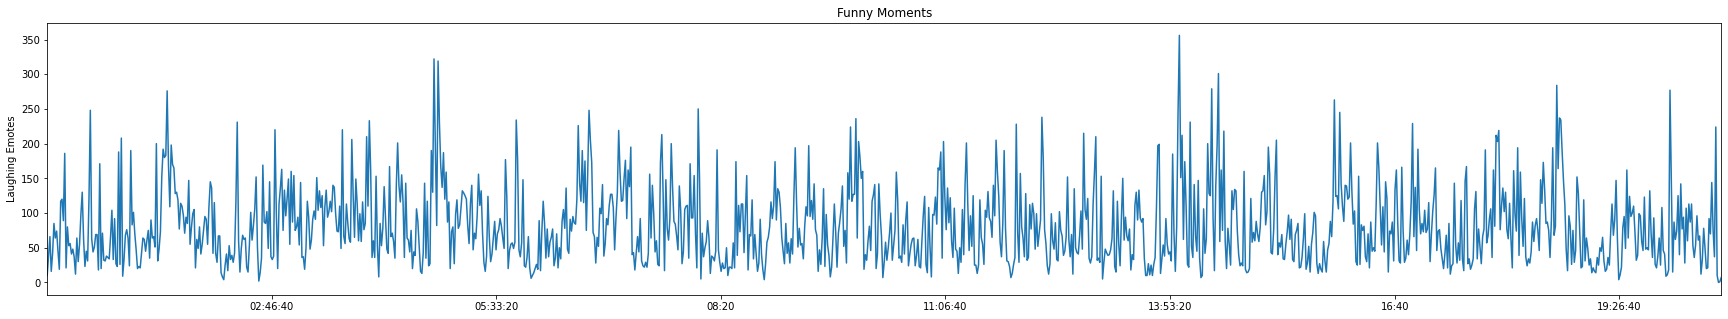

In [24]:
from matplotlib import dates
title='Funny Moments'
ylabel='Laughing Emotes'
xlabel=''

ax = laughing['message'].plot(figsize=(30,5),title=title)#,x_compat=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
#ax.xaxis.set_major_locator(dates.HourLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))

In [25]:
laughing = laughing[['message','seconds']]

In [26]:
funny_moments = laughing[laughing['message'] > 300]

In [27]:
len(funny_moments)

4

### When did the funny moments occur?

In [28]:
funny_moments.sort_values(by='message',ascending=False)

,message,seconds
hms,,
14:00:12,356,50412.0
04:47:12,322,17232.0
04:50:12,319,17412.0
14:29:12,301,52152.0
